In [ ]:
!pip install terratorch==0.99.7

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim

import terratorch
from terratorch.datamodules import Landslide4SenseNonGeoDataModule
from terratorch.datasets import Landslide4SenseNonGeo
from terratorch.tasks import SemanticSegmentationTask

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from huggingface_hub import snapshot_download

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('Landslide4sense.zip'):
    gdown.download("https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z")
    !unzip Landslide4sense.zip
  local_path = '.'
else:
  local_path = snapshot_download(repo_id='ibm-nasa-geospatial/Landslide4sense', repo_type="dataset", cache_dir='.')

In [ ]:
local_path

# Landslide4Sense Example

In [4]:
DATASET_PATH = local_path #os.path.join('dataset_dir', 'Landslide4sense')

In [5]:
# those are the recommended transforms for this task
transforms = [
    albumentations.HorizontalFlip(),
    albumentations.Flip(),
    albumentations.Resize(224, 224),
    albumentations.pytorch.transforms.ToTensorV2(),
]

In [6]:
# this datamodule allows access to the dataset in its various splits.
datamodule = Landslide4SenseNonGeoDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

In [ ]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

In [ ]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

In [ ]:
# checking datasets available bands
train_dataset.all_band_names

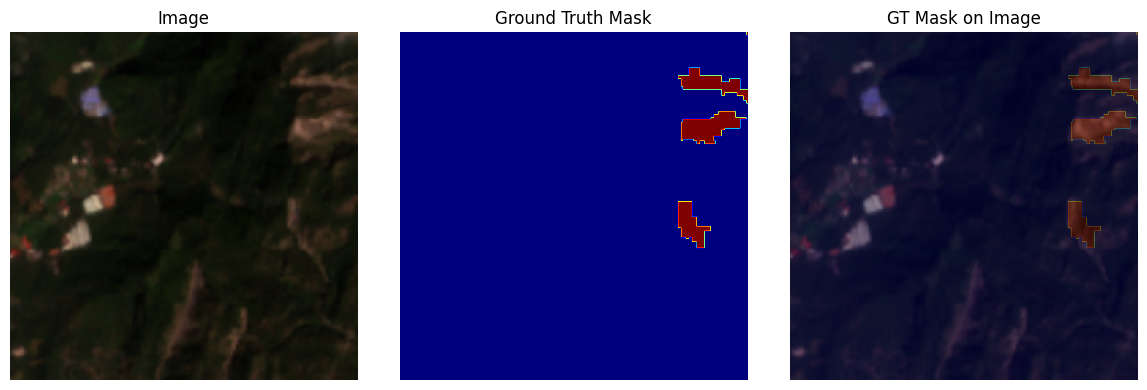

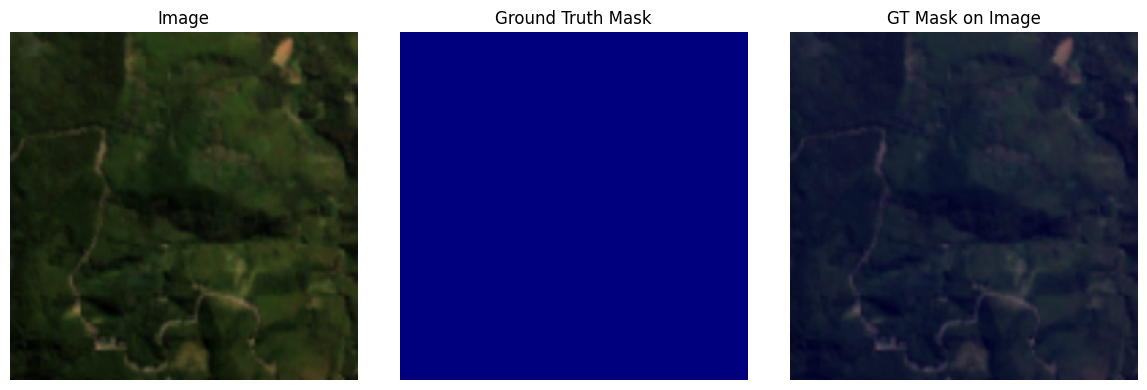

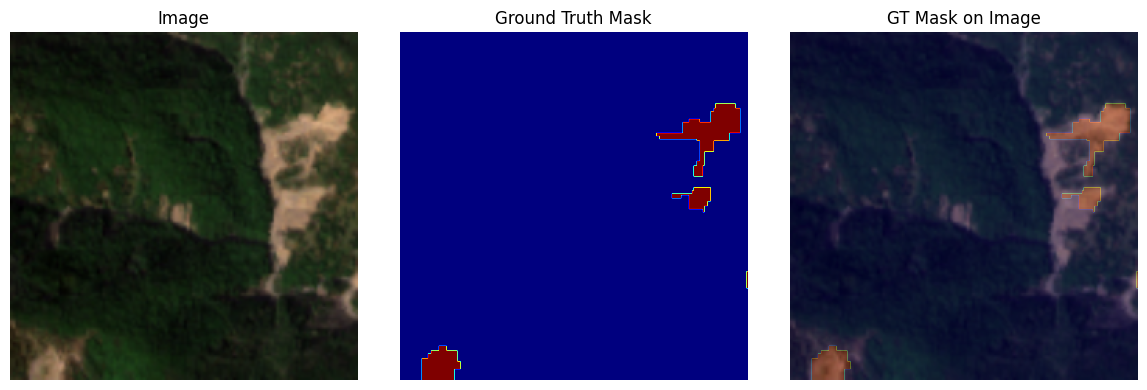

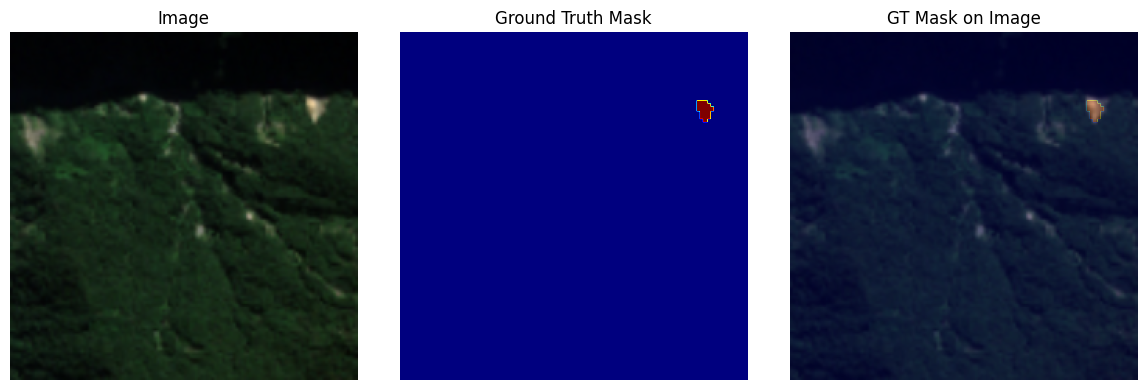

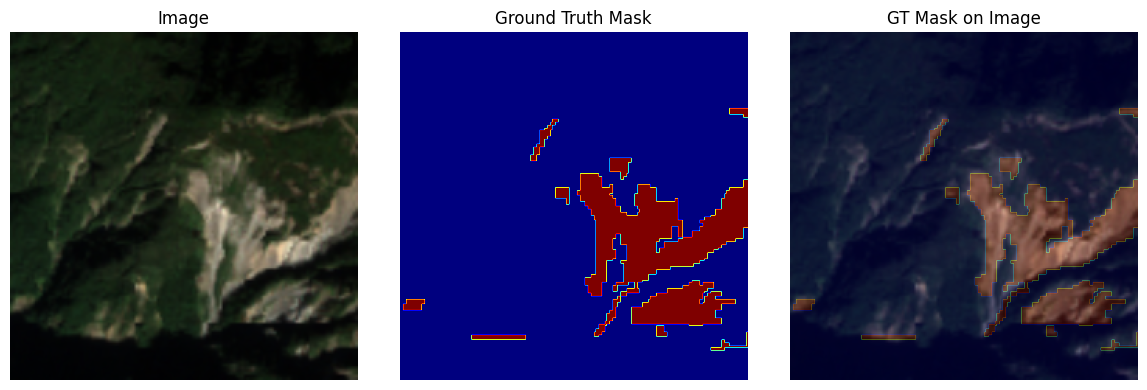

In [10]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [ ]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

In [ ]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

In [ ]:
pl.seed_everything(0)

# Logger
logger = TensorBoardLogger(
    save_dir="landslide4sense",
    name="tutorial"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# colab will kill the kernel after ~24 epochs, therefore stopping after two and pull the correct checkpoint after
max_epochs = 1 if 'google.colab' in sys.modules else 50


checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",      # Directory to save the checkpoints
    filename="epoch-{epoch:02d}", # Filename format
    save_top_k=-1,               # Save all checkpoints
    every_n_epochs=50,            # Save every epoch
    save_on_train_epoch_end=True # Ensure saving after each epoch
)


# Trainer
trainer = pl.Trainer(
    accelerator=device,
    num_nodes=1,
    logger = logger,
    max_epochs=max_epochs,
    check_val_every_n_epoch=2,
    log_every_n_steps=50,
    enable_checkpointing=True,
    default_root_dir="root_dir",
    callbacks=[checkpoint_callback],
)

# DataModule
data_module = Landslide4SenseNonGeoDataModule(
    batch_size=8,
    bands = ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 1,
        "num_classes": 2,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "head_channel_list": [128, 64],
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_vit_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_vit_600
            },
            {
                "name": "ReshapeTokensToImage"
            }
        ]
    },
    plot_on_val=False,
    loss="focal",
    lr=1.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    scheduler="StepLR",
    scheduler_hparams={"step_size": 10, "gamma": 0.9},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

In [ ]:
trainer.fit(model, datamodule=data_module)

In [ ]:
# on colab 50 epochs would run into a timeout (approx. 23 are possible), therefore grabbing a checkpoint from epoch 50
if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('landslide4sense.ckpt.zip'):
    gdown.download("https://drive.google.com/uc?id=12lFg4N2ibc4g6Pz8CiX5cJQNTuUXcTmF")
    !unzip landslide4sense.ckpt.zip

In [ ]:
trainer.test(model, datamodule=data_module, ckpt_path="./landslide4sense.ckpt")

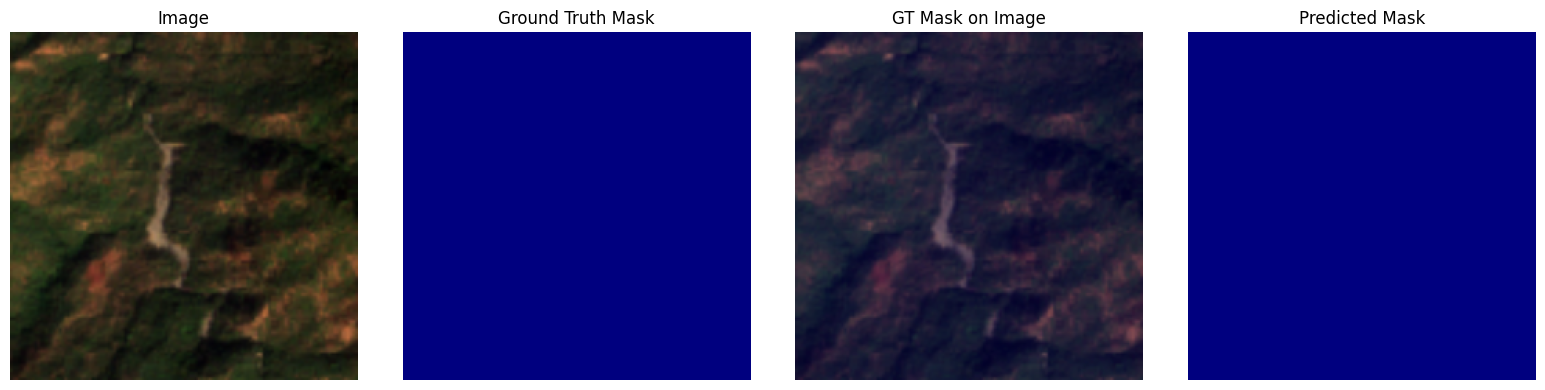

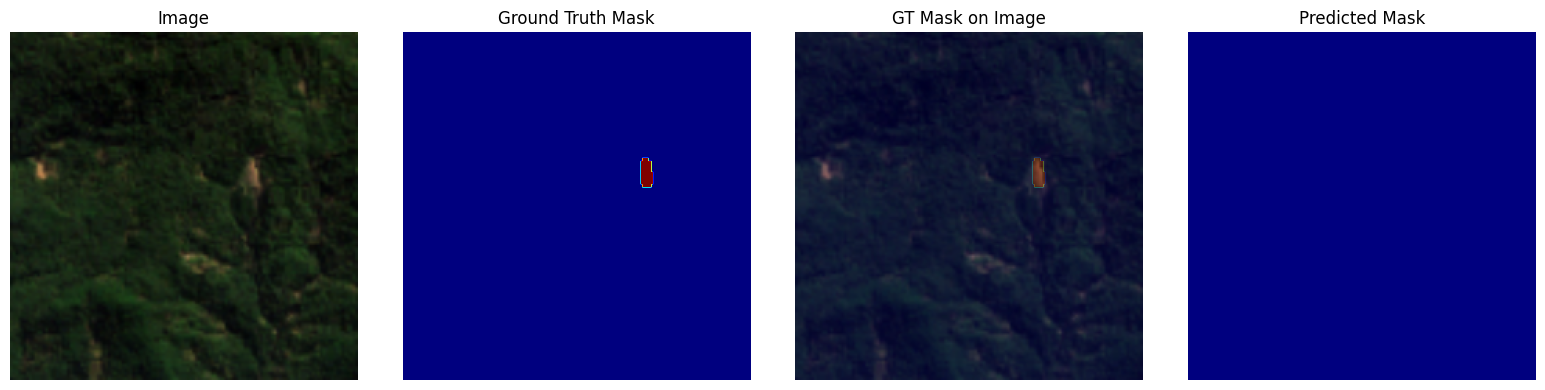

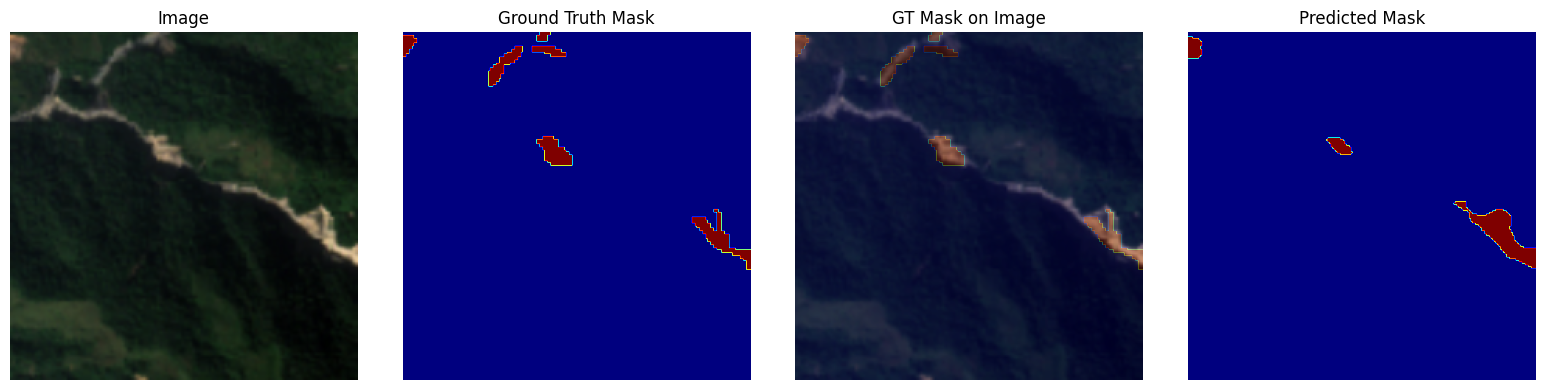

In [20]:
# now we can use the model for predictions and ploting!
best_ckpt_path = "./landslide4sense.ckpt"
model = SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_args=model.hparams.model_args,
    model_factory=model.hparams.model_factory
)

test_dataset = data_module.test_dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)
    masks = batch["mask"].to(device)
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5,8):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset.plot(sample)